При загрузке из колаба проблемы с отображением принтов, поэтому вот отдельно ссылка на тетрадку: https://colab.research.google.com/drive/1Kd131XJLWcQW53lXUNQ56ifM_tOIxIHO?usp=sharing

## 1. Обучите модель, которую разбирали на занятии



### Часть из лекционной тетрадки про подготовку корпуса

Мы будем использовать библиотеку [Transformers](https://huggingface.co/transformers/) от Hugging Face 

In [1]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 23.2 MB/s 
     |████████████████████████████████| 67 kB 7.1 MB/s 
     |████████████████████████████████| 895 kB 63.1 MB/s 
     |████████████████████████████████| 6.5 MB 51.4 MB/s 
     |████████████████████████████████| 596 kB 65.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Загрузим набор данных, который мы будем использовать для обучения и тестирования модели -- отзывы на приложения в Google Play.


In [2]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 72.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
100% 7.17M/7.17M [00:00<00:00, 109MB/s]


In [39]:
import transformers
from transformers import BertModel, Trainer, TrainingArguments, \
RobertaTokenizer, RobertaModel, BertTokenizer, PreTrainedTokenizerFast, \
BertForSequenceClassification, RobertaForSequenceClassification, AdamW, \
get_linear_schedule_with_warmup
import torch.nn.functional as F

import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from pprint import pprint
from torch import nn, optim
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader


In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 8, 6

In [5]:
df = pd.read_csv("reviews.csv")

In [6]:
df.shape

(15746, 11)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


In [8]:
from google.colab import data_table
data_table.disable_dataframe_formatter()

In [9]:
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


Посмотрим на распределение классов в выборке

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


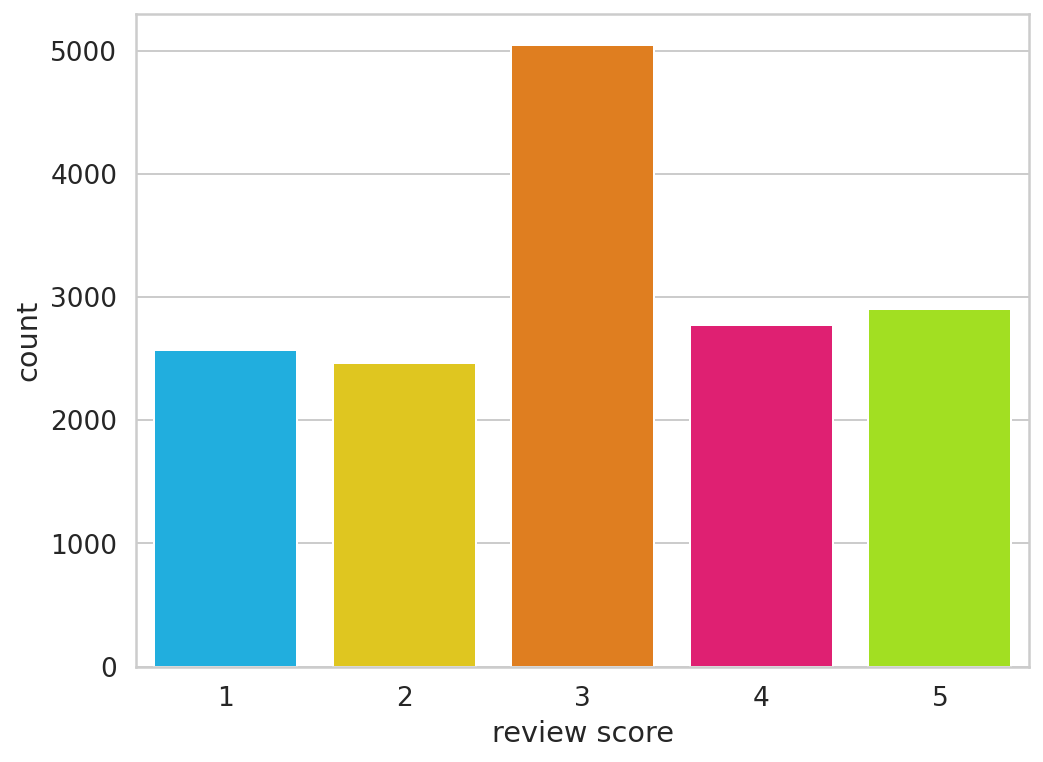

In [10]:
sns.countplot(df.score)
plt.xlabel('review score');

Можно видеть, что данные несбалансированы. 
Теперь приведем метки классов к другому виду -- разделим их на 3 класса: негативные, нейтральные и позитивные.

In [11]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [12]:
class_names = ['negative', 'neutral', 'positive']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


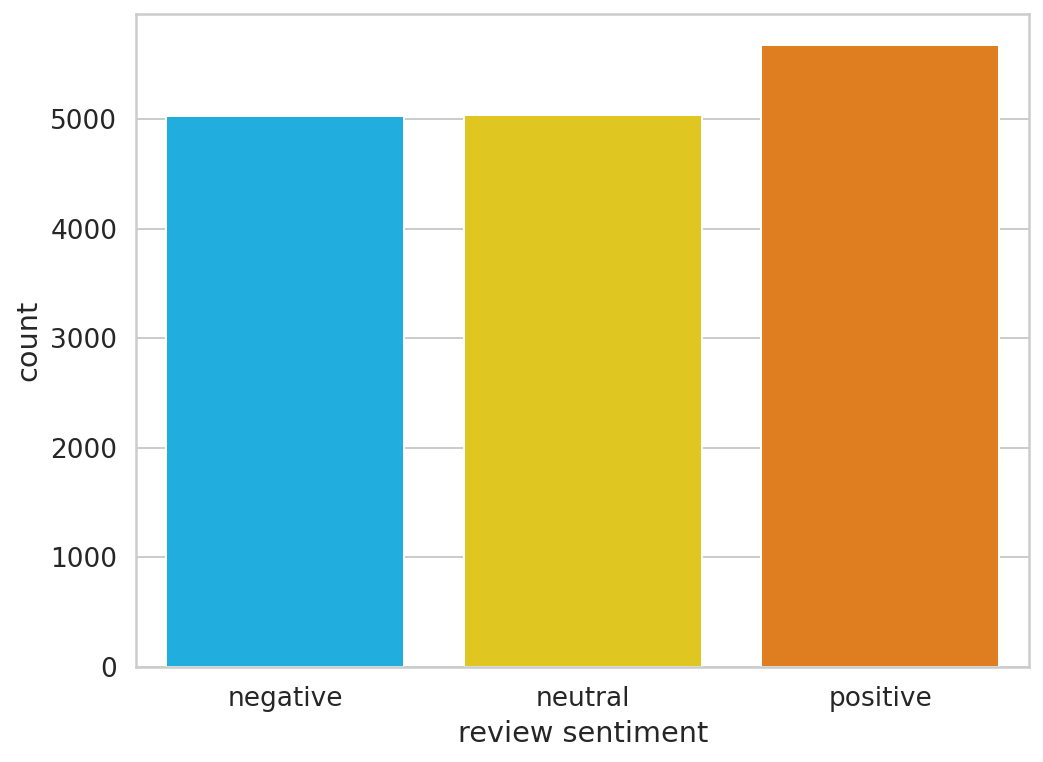

In [13]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

В таком виде классы почти сбалансированы.

### Предобработка



In [14]:
RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

я буду брать только часть от всего корпуса, потому что на полном колаб обещал обучение длиной больше часа...

In [15]:
print(f'Было {len(df)}')
separated_part, _ = train_test_split(df, test_size=0.4)
print(f'Стало {len(separated_part)}')

Было 15746
Стало 9447


разделение данных на трейн (0.8), вал (0.1) и тест (0.1):

In [16]:
train, test = train_test_split(separated_part, test_size=0.2)
train_texts = train.content.to_list()
train_labels = train.sentiment.to_list()
val_texts, test_texts, val_labels, test_labels = train_test_split(test.content.to_list(),
                                                                  test.sentiment.to_list(),
                                                                  test_size=0.5)

Предобученный [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [15]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

энкодинг этих данных:

In [19]:
train_encodings = tokenizer(train_texts, truncation=True, max_length=256,
                            padding='max_length', return_token_type_ids=False)
val_encodings = tokenizer(val_texts, truncation=True, max_length=256,
                          padding='max_length', return_token_type_ids=False)
test_encodings = tokenizer(test_texts, truncation=True, max_length=256,
                           padding='max_length', return_token_type_ids=False)

создание датасета для трейнера:

In [21]:
class GPReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = GPReviewDataset(train_encodings, train_labels)
val_dataset = GPReviewDataset(val_encodings, val_labels)
test_dataset = GPReviewDataset(test_encodings, test_labels)

кастомная метрика:

In [24]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds,
                                                               average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

### Модель

описание класса модели (из тетрадки с лекции + добавление лосса):

In [24]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super().__init__()
    self.bert = BertModel.from_pretrained('bert-base-cased')
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_classes = n_classes
    self.loss_fct = nn.CrossEntropyLoss()
  
  def forward(self, input_ids, attention_mask, labels):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False)
    output = self.out(self.drop(pooled_output))

    loss = self.loss_fct(output, labels)

    return (loss, output)

In [25]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Обучение и оценка

инициализация трейнера и запуск обучения:

In [26]:
# заморозка слоёв
freeze_layers = list(range(5))
for layer_id in freeze_layers:
    for param in list(model.bert.encoder.layer[layer_id].parameters()):
        param.requires_grad = False

параметры для трейнера:

In [27]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=8,   # batch size per device during training
    per_device_eval_batch_size=8,    # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy='epoch',
)

In [28]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics    # metrics to evaluate
)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 7557
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1890


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.006600,0.648119,0.707937,0.699460,0.703244,0.698265
2,0.565600,0.603499,0.741799,0.737732,0.740999,0.736158


Saving model checkpoint to ./results/checkpoint-500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 945
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-1000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-1500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 945
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1890, training_loss=0.7051400684175038, metrics={'train_runtime': 1284.769, 'train_samples_per_second': 11.764, 'train_steps_per_second': 1.471, 'total_flos': 0.0, 'train_loss': 0.7051400684175038, 'epoch': 2.0})

запуск валидации:

In [29]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 945
  Batch size = 8


{'epoch': 2.0,
 'eval_accuracy': 0.7417989417989418,
 'eval_f1': 0.7377322141657094,
 'eval_loss': 0.6034985780715942,
 'eval_precision': 0.7409989962110739,
 'eval_recall': 0.7361582352394199,
 'eval_runtime': 29.2375,
 'eval_samples_per_second': 32.321,
 'eval_steps_per_second': 4.07}

и тестирование на "финальном" датасете:

In [30]:
trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")

***** Running Evaluation *****
  Num examples = 945
  Batch size = 8


{'epoch': 2.0,
 'test_accuracy': 0.7322751322751323,
 'test_f1': 0.7324148614220983,
 'test_loss': 0.6815932393074036,
 'test_precision': 0.7340965124398272,
 'test_recall': 0.7311142658957669,
 'test_runtime': 29.2464,
 'test_samples_per_second': 32.312,
 'test_steps_per_second': 4.069}

In [32]:
del model

In [33]:
del tokenizer

## 2. Измените модель, чтобы помимо выхода с пуллер-слоя использовался эмбеддинг cls-токена с последнего слоя

код повторяет предыдущую часть, за исключением изменённого класса модели. здесь нет отдельной предобработки, потому что класс модели остаётся тот же

### Модель

In [44]:
class SentimentClassifierCLS(nn.Module):

  def __init__(self, n_classes):
    super().__init__()
    self.bert = BertModel.from_pretrained('bert-base-cased')
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size*2, n_classes)
    self.n_classes = n_classes
    self.loss_fct = nn.CrossEntropyLoss()
  
  def forward(self, input_ids, attention_mask, labels):
    last_hidden_state, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False)
    
    cls_token = last_hidden_state[:,0,:] # первый элемент из seq_len
    # добавляю cls приклеиванием к аутпуту справа
    added_cls = torch.cat((pooled_output, cls_token), dim=1)
    output = self.out(self.drop(added_cls))

    loss = self.loss_fct(output, labels)

    return (loss, output)

In [45]:
model_cls = SentimentClassifierCLS(len(class_names))
model_cls = model_cls.to(device)

loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file https://huggingface.co/bert-base-cased/resolve/main/pytorch_model.bin from cache at /

### Обучение и оценка

In [46]:
# заморозка слоёв
freeze_layers = list(range(5))
for layer_id in freeze_layers:
    for param in list(model_cls.bert.encoder.layer[layer_id].parameters()):
        param.requires_grad = False

параметры для трейнера те же, как в первой модели, чтобы можно было сравнивать:

In [47]:
training_args = TrainingArguments(
    output_dir='./results_cls',      # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=8,   # batch size per device during training
    per_device_eval_batch_size=8,    # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy='epoch',
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [48]:
trainer = Trainer(
    model=model_cls,                     # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics    # metrics to evaluate
)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 7557
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1890


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.876900,0.655675,0.710053,0.698898,0.698024,0.700263
2,0.485900,0.613251,0.747090,0.742399,0.743819,0.741735


Saving model checkpoint to ./results_cls/checkpoint-500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 945
  Batch size = 8
Saving model checkpoint to ./results_cls/checkpoint-1000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results_cls/checkpoint-1500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 945
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1890, training_loss=0.6811919671517831, metrics={'train_runtime': 1286.7832, 'train_samples_per_second': 11.746, 'train_steps_per_second': 1.469, 'total_flos': 0.0, 'train_loss': 0.6811919671517831, 'epoch': 2.0})

In [49]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 945
  Batch size = 8


{'epoch': 2.0,
 'eval_accuracy': 0.7470899470899471,
 'eval_f1': 0.7423988661602413,
 'eval_loss': 0.613251268863678,
 'eval_precision': 0.7438190039934227,
 'eval_recall': 0.7417351172003014,
 'eval_runtime': 29.1861,
 'eval_samples_per_second': 32.378,
 'eval_steps_per_second': 4.077}

In [50]:
trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")

***** Running Evaluation *****
  Num examples = 945
  Batch size = 8


{'epoch': 2.0,
 'test_accuracy': 0.7407407407407407,
 'test_f1': 0.742377235982112,
 'test_loss': 0.6912916302680969,
 'test_precision': 0.7452586447684487,
 'test_recall': 0.7410599267523716,
 'test_runtime': 29.2025,
 'test_samples_per_second': 32.36,
 'test_steps_per_second': 4.075}

Результат после добавления cls-токена немного, но улучшился по всем четырём метрикам: без него везде было 0.73 (с округлением), с ним стало 0.74, а пресижн с округлением до десятых выходит даже 0.75

In [51]:
del model_cls

## 3. Примените к данным готовую модель для классификации последовательности

Я возьму Roberta-base

### Предобработка

In [17]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

энкодинг данных:

In [18]:
train_encodings = tokenizer(train_texts, truncation=True, max_length=256,
                            padding='max_length', return_token_type_ids=False)
val_encodings = tokenizer(val_texts, truncation=True, max_length=256,
                          padding='max_length', return_token_type_ids=False)
test_encodings = tokenizer(test_texts, truncation=True, max_length=256,
                           padding='max_length', return_token_type_ids=False)

создание датасета:

In [19]:
class GPReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = GPReviewDataset(train_encodings, train_labels)
val_dataset = GPReviewDataset(val_encodings, val_labels)
test_dataset = GPReviewDataset(test_encodings, test_labels)

### Модель
загрузка модели:

In [20]:
roberta = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels = 3)
roberta = roberta.to(device)

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

In [21]:
# заморозка слоёв
freeze_layers = list(range(5))
for layer_id in freeze_layers:
    for param in list(roberta.roberta.encoder.layer[layer_id].parameters()):
        param.requires_grad = False

### Обучение и оценка
аргументы трейнера:

In [22]:
training_args = TrainingArguments(
    output_dir='./roberta',          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=8,   # batch size per device during training
    per_device_eval_batch_size=8,    # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy='epoch',
)

обучение:

In [25]:
trainer = Trainer(
    model=roberta,                       # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics    # metrics to evaluate
)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 7557
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1890


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.837300,0.692043,0.701587,0.681323,0.685897,0.691096
2,0.643900,0.607431,0.738624,0.729893,0.730985,0.732407


Saving model checkpoint to ./roberta/checkpoint-500
Configuration saved in ./roberta/checkpoint-500/config.json
Model weights saved in ./roberta/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 945
  Batch size = 8
Saving model checkpoint to ./roberta/checkpoint-1000
Configuration saved in ./roberta/checkpoint-1000/config.json
Model weights saved in ./roberta/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./roberta/checkpoint-1500
Configuration saved in ./roberta/checkpoint-1500/config.json
Model weights saved in ./roberta/checkpoint-1500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 945
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1890, training_loss=0.7279907438490126, metrics={'train_runtime': 666.4468, 'train_samples_per_second': 22.678, 'train_steps_per_second': 2.836, 'total_flos': 1988348097770496.0, 'train_loss': 0.7279907438490126, 'epoch': 2.0})

оценка:

In [26]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 945
  Batch size = 8


{'epoch': 2.0,
 'eval_accuracy': 0.7386243386243386,
 'eval_f1': 0.7298928948713055,
 'eval_loss': 0.6074314117431641,
 'eval_precision': 0.7309850186097769,
 'eval_recall': 0.7324070316513197,
 'eval_runtime': 14.0554,
 'eval_samples_per_second': 67.234,
 'eval_steps_per_second': 8.467}

In [27]:
trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")

***** Running Evaluation *****
  Num examples = 945
  Batch size = 8


{'epoch': 2.0,
 'test_accuracy': 0.7174603174603175,
 'test_f1': 0.7167583727188706,
 'test_loss': 0.6892314553260803,
 'test_precision': 0.7161616549542865,
 'test_recall': 0.7193242693943419,
 'test_runtime': 14.077,
 'test_samples_per_second': 67.131,
 'test_steps_per_second': 8.454}

Эта модель роберты справилась чуть хуже, чем предыдущие берты: 0.72 с округлением по всем метрикам вместо 0.73 у берта без cls и 0.74 у берта с cls

## 5. Выберите на сайте google play три понравившихся вам отзыва, относящиеся к разным классам. Покажите, как на них работает любая из обученных моделей
это отзывы на приложение с интерактивной картой звёзного неба. Отзывы на 5, 3 и 1 звезду соответственно

In [28]:
pos_review = "Perfect, as a beginner to the hobby it gives you real \
time access to almost all space objects. It has a night mode so your \
eyes can be adjusted for proper night sky viewing. If you have any \
interest in stargazing or astronomy this is the app no questions asked. \
Wish all app developers were this chil..."

neut_review = "It's got a nice display but the sensor mode is exactly \
inverted of my actual info. Facing west the compass shows me pointing \
east. Google Maps shows the right direction so I don't think it's my sensor. \
Uninstalled because I can't get the thing facing right."

neg_review = "Can't calibrate the compass no matter how many times I move \
my phone in a figure 8 motion. Even paif for the upgrade - very dissatisfied!"

Проверю эти отзывы последней уже загруженной в память моделью роберта, чтобы не словить out of memory

токенизация для отзывов:

In [29]:
def encode_one(text):
    return tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            return_token_type_ids=False,
            padding=True,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
            )

In [30]:
encoded_pos = encode_one(pos_review)
encoded_neut = encode_one(neut_review)
encoded_neg = encode_one(neg_review)

предсказания последней модели роберта:

In [37]:
def predict_one(encoded_text):
    input_ids = encoded_text['input_ids'].to(device)
    attention_mask = encoded_text['attention_mask'].to(device)

    output = roberta(input_ids, attention_mask)
    prediction = torch.argmax(output['logits'], dim=1)

    return {class_names[prediction]}

In [42]:
print(pos_review, predict_one(encoded_pos), '\n')
print(neut_review, predict_one(encoded_neut), '\n')
print(neg_review, predict_one(encoded_neg), '\n')

Perfect, as a beginner to the hobby it gives you real time access to almost all space objects. It has a night mode so your eyes can be adjusted for proper night sky viewing. If you have any interest in stargazing or astronomy this is the app no questions asked. Wish all app developers were this chil... {'positive'} 

It's got a nice display but the sensor mode is exactly inverted of my actual info. Facing west the compass shows me pointing east. Google Maps shows the right direction so I don't think it's my sensor. Uninstalled because I can't get the thing facing right. {'negative'} 

Can't calibrate the compass no matter how many times I move my phone in a figure 8 motion. Even paif for the upgrade - very dissatisfied! {'negative'} 



Отзывы на 5 и на 1 звезду верно классифицировались как положительный и отрицательный соответственно, но вот отзыв на 3 звезды ошибочно распознался моделью как негативный вместо нейтрального